In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h1>Load data</h1>

In [2]:
file_name = "iris.data.csv"

In [3]:
#load the dataset into memory
dataset = pd.read_csv(file_name,header=None,\
                      names=['sepal_length','sepal_width','petal_length','petal_width','species'])
#check several examples of data
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h1>Data preprocessing</h1>

In [4]:
#simple function to process the data.
"""
input:
    data: iris dataset
    num_features: 2 => select only petal width and petal width.
                  4 => select all features
    flower: 'Iris-setosa' => labels of Iris-setosa will be 1 and others will be 0
            'Iris-virginica' => labels of Iris-virginica will be 1 and others will be 0
            'None' => use one-hot encoding to represent the labels

return:
    x: normalized & shuffled data
    y: labels
"""
def data_preprocessing(data,num_features,flower=None):
    if num_features==2:
        features = data.columns[2:4]
    else:
        features = data.columns[0:4]
    labels = dataset.columns[4]
    print(features)
    print(labels)
    #normalize the data
    data_norm = pd.DataFrame(data)
    for feature in features:
        data[feature] = (data[feature]-data[feature].mean())/data[feature].std()

    #shuffle the data
    indices = data_norm.index.tolist()
    indices = np.array(indices)
    np.random.shuffle(indices)
    x = data_norm.reindex(indices)[features]
    y = data_norm.reindex(indices)[labels]
    if flower=='Iris-setosa':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-setosa' else 0
        y = y.values.reshape(len(y),1)
    elif flower=='Iris-virginica':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-virginica' else 0
        y = y.values.reshape(len(y),1)
    else:
        y = get_dummies(y)
    return x,y

<h1>Part a:

In [5]:
x_1,y_1 = data_preprocessing(dataset,2,flower='Iris-setosa')
#generate traning and validation sets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1,y_1,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameters</h2>

In [6]:
#controlling variables
batch_size = 5
lr = 0.01
num_of_steps = 100

<h2>Define Placeholder and Variables</h2>

In [7]:
tf.reset_default_graph()
features = ['petal_length', 'petal_width']



#define the placeholder to feed the training data later
X = tf.placeholder(tf.float32, shape=[None,2], name="X")
Y = tf.placeholder(tf.float32, shape=[None,1], name="Y")


#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

Instructions for updating:
Colocations handled automatically by placer.


<h2>Define update rule and accuracy</h2>

In [8]:
#define the predicted output label, Tensorflow doesn't have step function, we use tf.round to do that
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

<h2>Execute training</h2>

In [9]:
#initialize tensorflow variables
init = tf.global_variables_initializer()

epoch_list = []
accuracy_list = []

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(num_of_steps):
        error_sum = 0
        #every iteration we run optimization on the training data X and labels Y
        _, error_check = sess.run([step,error],feed_dict={X: x_train_1, Y: y_train_1})
        
        #sum up the error for an accuracy check
        error_sum += np.sum(np.absolute(error_check))
        current_accuracy = (105 - error_sum)/105
        
        epoch_list.append(i)
        accuracy_list.append(current_accuracy)
            
        if i % 10 == 0:
            print('Epoch ', i)
            print('Accuracy', current_accuracy)
    
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    W = np.squeeze(sess.run(W))
    b = np.squeeze(sess.run(b))

    #test testing accuracy
    error_check = sess.run([error], feed_dict={X: x_test_1, Y: y_test_1})
    error_sum += np.sum(np.absolute(error_check))
    
    print('Testing set')
    print('Accuracy', (45 - error_sum)/45)

Epoch  0
Accuracy 0.047619047619047616
Epoch  10
Accuracy 1.0
Epoch  20
Accuracy 1.0
Epoch  30
Accuracy 1.0
Epoch  40
Accuracy 1.0
Epoch  50
Accuracy 1.0
Epoch  60
Accuracy 1.0
Epoch  70
Accuracy 1.0
Epoch  80
Accuracy 1.0
Epoch  90
Accuracy 1.0
Testing set
Accuracy 1.0


<h2>Plot</h2>

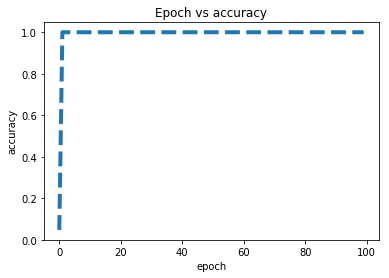

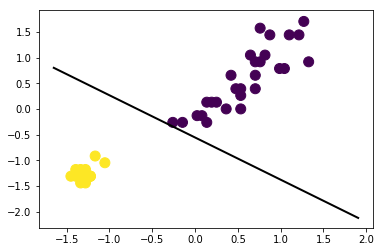

In [10]:
plt.figure()

# plot epoch vs accuracy
plt.plot(epoch_list,accuracy_list,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy')

plt.figure()
plot_x = np.array([np.min(x_test_1.values[:, 0] - 0.2), np.max(x_test_1.values[:, 1]+0.2)])
plot_y = 1 / W[1] * (-W[0] * plot_x - b)

plt.scatter(x_test_1.values[:, 0], x_test_1.values[:, 1], c=np.squeeze(y_test_1), s=100, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.show()

For part a I am getting 100 percent accuracy for both the training and the testing data set. What this tells me about setosa w.r.t the other two iris species is that the setosa is linearly separable. Looking at the data we can see this is the case. 

<h1>Part b:</h1>

In [11]:
x_2,y_2 = data_preprocessing(dataset,2,flower='Iris-virginica')
#generate traning and validation sets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2,y_2,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameter</h2>

In [12]:
#controlling variables
batch_size = 5
lr = 0.01
num_of_steps = 100

<h2>Define Placeholder and Variables</h2>

In [13]:
tf.reset_default_graph()


X = tf.placeholder(tf.float32, shape=[None,2], name="X")
Y = tf.placeholder(tf.float32, shape=[None,1], name="Y")


#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

<h2>Define update rule and accuracy</h2>

In [14]:
#define the predicted output label, Tensorflow doesn't have step function, we use tf.round to do that
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

<h2>Execute training</h2>

In [15]:
#initialize tensorflow variables
init = tf.global_variables_initializer()

epoch_list = []
accuracy_list = []

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)

    #training for number of iterations
    for i in range(num_of_steps):
        error_sum = 0
        #every iteration we run optimization on the training data X and labels Y
        _, error_check = sess.run([step,error],feed_dict={X: x_train_2, Y: y_train_2})
        
        #sum up the error for an accuracy check
        error_sum += np.sum(np.absolute(error_check))
        current_accuracy = (105 - error_sum)/105
        
        epoch_list.append(i)
        accuracy_list.append(current_accuracy)
            
        if i % 10 == 0:
            print('Epoch ', i)
            print('Accuracy', current_accuracy)
    
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    W = np.squeeze(sess.run(W))
    b = np.squeeze(sess.run(b))

    #test testing accuracy
    error_check = sess.run([error], feed_dict={X: x_test_2, Y: y_test_2})
    error_sum += np.sum(np.absolute(error_check))

    print('Testing set')
    print('Accuracy', (45 - error_sum)/45)

Epoch  0
Accuracy 0.3047619047619048
Epoch  10
Accuracy 0.9619047619047619
Epoch  20
Accuracy 0.9619047619047619
Epoch  30
Accuracy 0.9619047619047619
Epoch  40
Accuracy 0.9619047619047619
Epoch  50
Accuracy 0.9619047619047619
Epoch  60
Accuracy 0.9714285714285714
Epoch  70
Accuracy 0.9809523809523809
Epoch  80
Accuracy 0.9809523809523809
Epoch  90
Accuracy 0.9809523809523809
Testing set
Accuracy 0.8888888888888888


<h2>Plot</h2>

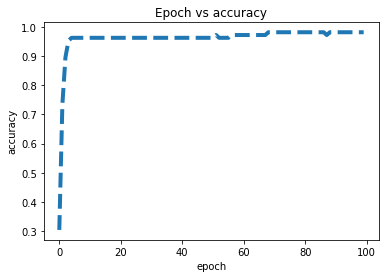

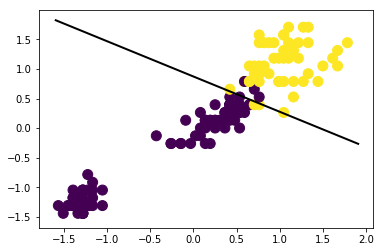

In [16]:
plt.figure()

# plot epoch vs accuracy
plt.plot(epoch_list,accuracy_list,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy')

plt.figure()
plot_x = np.array([np.min(x_test_2.values[:, 0] - 0.2), np.max(x_test_2.values[:, 1]+0.2)])
plot_y = 1 / W[1] * (-W[0] * plot_x - b)

plt.scatter(x_test_2.values[:, 0], x_test_2.values[:, 1], c=np.squeeze(y_test_2), s=100, cmap='viridis')
plt.scatter(x_train_2.values[:, 0], x_train_2.values[:, 1], c=np.squeeze(y_train_2), s=100, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.show()

For part b I am getting 98 percent accuracy for the training data and 88 percent accuracy for the testing data set. What this tells me about virginica w.r.t the other two iris species is that the virginica is not linearly separable. Looking at the data we can see this is the case. 

<h1>Part c:</h1>

In [29]:
x_3,y_3 = data_preprocessing(dataset,4)
#generate traning and validation sets
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3,y_3,test_size=0.3)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameters</h2>

In [36]:
#learning rate
lr = 0.01
#number of traning steps
num_steps = 100

#network parameters
n_hidden_1 = 256
n_hidden_2 = 128
num_input = 4
num_classes = 3

<h2>Define placehoder and variables</h2>

In [37]:
tf.reset_default_graph()

#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden_1]),name='W1'),
    'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]),name='W2'),
    'Wout': tf.Variable(tf.random_normal([n_hidden_2, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden_1]),name='b1'),
    'b2': tf.Variable(tf.zeros(shape=[n_hidden_2]),name='b2'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

<h2>Define the neural network</h2>

In [38]:
#define a neural net model
def neural_net(x):
    layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
    layer_2_out = tf.nn.relu(tf.add(tf.matmul(layer_1_out,weights['W2']),biases['b2']))
    out = tf.add(tf.matmul(layer_2_out,weights['Wout']),biases['bout'])
    return out

<h2>Define cost function and accuracy</h2>

In [39]:
#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

<h2>Execute training</h2>

In [40]:
#Initialize the variables
init = tf.global_variables_initializer()

epoch_list = []
accuracy_list = []

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #run optimization
        sess.run(train_op, feed_dict={X:x_train_3, Y:y_train_3})
        acc = sess.run(accuracy,feed_dict={X:x_train_3, Y:y_train_3})
        
        epoch_list.append(i)
        accuracy_list.append(acc)
        
        if i % 20 ==0:
            print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
    
    print("Training finished!")
    
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X:x_test_3, Y:y_test_3}))

step 0, Accuracy= 0.705
step 20, Accuracy= 0.924
step 40, Accuracy= 0.981
step 60, Accuracy= 1.000
step 80, Accuracy= 1.000
Training finished!
Testing Accuracy: 0.95555556


<h2>Plot</h2>

Text(0.5, 1.0, 'Epoch vs accuracy')

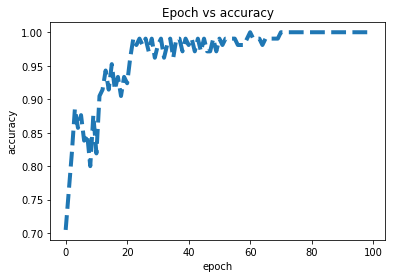

In [41]:
plt.figure()

# plot epoch vs accuracy
plt.plot(epoch_list,accuracy_list,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy')